In [1]:
# Data manipulation
# ==============================================================================
import numpy as np
import pandas as pd

# Plots
# ==============================================================================
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
plt.rcParams['lines.linewidth'] = 1.5
plt.rcParams['font.size'] = 10

# Modeling and Forecasting
# ==============================================================================

from sklearn.metrics import mean_squared_error,mean_absolute_error,mean_absolute_percentage_error,max_error, r2_score,explained_variance_score


# Warnings configuration
# ==============================================================================
import warnings
# warnings.filterwarnings('ignore')

import itertools
import statsmodels.api as sm



In [2]:
df = pd.read_excel("finaldata.xlsx")

In [3]:
df.drop_duplicates(subset=['TimeStamp'])

,TimeStamp,IE Generation,IE Demand,IE Wind Generation,SNSP,Hydro Run-of-River,Fossil hard coal,Fossil oil,Fossil peat,Fossil gas,temp,rhum,ElectricityPrice,day,month,hour,dayofweek
0,2019-01-01 00:00:00,2444.54,3005.92,599.15,0.4215,128.9,0.0,35.3,170.1,979.2,8.8,80.0,70.280,1,1,0,1
1,2019-01-01 01:00:00,2326.80,2865.43,626.40,0.4324,128.4,0.0,28.2,225.0,808.3,8.3,82.0,65.180,1,1,1,1
2,2019-01-01 02:00:00,1993.39,2613.60,513.24,0.4485,123.4,0.0,35.5,224.6,616.3,8.4,82.0,60.910,1,1,2,1
3,2019-01-01 03:00:00,1752.69,2470.13,489.53,0.4832,124.1,0.0,35.6,190.7,451.6,8.6,82.0,65.160,1,1,3,1
4,2019-01-01 04:00:00,1717.17,2384.35,378.44,0.4460,124.4,0.0,36.0,197.1,458.5,8.4,85.0,65.160,1,1,4,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30615,2022-06-29 19:00:00,3978.34,3879.64,367.16,0.0931,116.3,456.0,146.4,96.5,1658.4,15.8,73.0,245.195,29,6,19,2
30616,2022-06-29 20:00:00,3843.57,3725.62,311.32,0.0751,92.3,450.7,123.8,93.6,1678.3,14.5,80.0,245.195,29,6,20,2
30617,2022-06-29 21:00:00,3796.31,3601.76,290.98,0.0668,80.5,450.7,122.2,93.6,1649.8,14.0,77.0,228.590,29,6,21,2
30618,2022-06-29 22:00:00,3754.00,3467.82,309.83,0.0732,59.7,340.1,121.5,96.1,1630.2,13.3,82.0,228.590,29,6,22,2


In [4]:
data=df.copy()
data['TimeStamp'] = pd.to_datetime(data['TimeStamp'], format='%Y-%m-%dT%H:%M:%SZ')
data = data.set_index('TimeStamp')
data = data.asfreq('H')
data = data.sort_index()
data.head(2)

,IE Generation,IE Demand,IE Wind Generation,SNSP,Hydro Run-of-River,Fossil hard coal,Fossil oil,Fossil peat,Fossil gas,temp,rhum,ElectricityPrice,day,month,hour,dayofweek
TimeStamp,,,,,,,,,,,,,,,,
2019-01-01 00:00:00,2444.54,3005.92,599.15,0.4215,128.9,0.0,35.3,170.1,979.2,8.8,80.0,70.28,1.0,1.0,0.0,1.0
2019-01-01 01:00:00,2326.80,2865.43,626.40,0.4324,128.4,0.0,28.2,225.0,808.3,8.3,82.0,65.18,1.0,1.0,1.0,1.0


In [5]:
data=data.fillna(method='ffill')
data['ElectricityPrice'] = data['ElectricityPrice'].fillna(0)
data['IE Demand'] = data['IE Demand'].fillna(0)

In [6]:
data=data.drop(data[data.index>pd.to_datetime('31-12-2021  23:00:00')].index)
data.shape

(26304, 16)

In [7]:
min_date = data.index.min()
max_date = data.index.max()
print("Min:", min_date, "Max:", max_date)
train_percent = .80
time_between = max_date - min_date
train_cutoff = min_date + train_percent*time_between
train_cutoff

Min: 2019-01-01 00:00:00 Max: 2021-12-31 23:00:00


Timestamp('2021-05-26 18:24:00', freq='H')

In [8]:
train_df = data[data.index <= train_cutoff]
test_df = data[data.index > train_cutoff]

print("Train:", train_df.index.min(), train_df.index.max(), len(train_df))
print("Test:", test_df.index.min(), test_df.index.max(), len(test_df))

Train: 2019-01-01 00:00:00 2021-05-26 18:00:00 21043
Test: 2021-05-26 19:00:00 2021-12-31 23:00:00 5261


In [9]:
exogenous_features = list(data)
exogenous_features.remove('ElectricityPrice')
exogenous_features

['IE Generation',
 'IE Demand',
 'IE Wind Generation',
 'SNSP',
 'Hydro Run-of-River',
 'Fossil hard coal',
 'Fossil oil',
 'Fossil peat',
 'Fossil gas',
 'temp',
 'rhum',
 'day',
 'month',
 'hour',
 'dayofweek']

In [10]:
# Define p, d, q params to take any value between 0 and 2
p = d = q = range(0, 2)

# Generate all different combinations of p, d, q
pdq = list(itertools.product(p, d, q))

# Generate all different combos of seasonal P, D, Q
seasonal_pdq = [(x[0], x[1], x[2], 7) for x in list(itertools.product(p, d, q))]

In [11]:
warnings.filterwarnings("ignore")


min_aic = float('inf')
min_params = None
min_params_seasonal = None
min_model = None

for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(
                train_df['ElectricityPrice'],
                exog=train_df.loc[:, exogenous_features],
                order=param,
                seasonal_order=param_seasonal,
                enforce_stationarity=False,
                enforce_invertibility=False)
            results = mod.fit()
            if results.aic < min_aic:
                min_aic = results.aic
                min_params = param
                min_params_seasonal = param_seasonal
                min_model = results
            print('ARIMA{}x{}: aic={}'.format(param, param_seasonal, results.aic))
        except:
            continue

ARIMA(0, 0, 0)x(0, 0, 0, 7): aic=216551.4838144031
ARIMA(0, 0, 0)x(0, 0, 1, 7): aic=197081.9378684031
ARIMA(0, 0, 0)x(0, 1, 0, 7): aic=196697.36509926908
ARIMA(0, 0, 0)x(0, 1, 1, 7): aic=190772.93374249418
ARIMA(0, 0, 0)x(1, 0, 0, 7): aic=192715.5278517938
ARIMA(0, 0, 0)x(1, 0, 1, 7): aic=190569.7791514474
ARIMA(0, 0, 0)x(1, 1, 0, 7): aic=193243.00575402167
ARIMA(0, 0, 0)x(1, 1, 1, 7): aic=190276.7333807082
ARIMA(0, 0, 1)x(0, 0, 0, 7): aic=188914.81501324335
ARIMA(0, 0, 1)x(0, 0, 1, 7): aic=189097.31659372966
ARIMA(0, 0, 1)x(0, 1, 0, 7): aic=182205.1015524895
ARIMA(0, 0, 1)x(0, 1, 1, 7): aic=176145.33736002006
ARIMA(0, 0, 1)x(1, 0, 0, 7): aic=188757.08963506218
ARIMA(0, 0, 1)x(1, 0, 1, 7): aic=186722.04129743238
ARIMA(0, 0, 1)x(1, 1, 0, 7): aic=182481.71665092948
ARIMA(0, 0, 1)x(1, 1, 1, 7): aic=180629.6436698296
ARIMA(0, 1, 0)x(0, 0, 0, 7): aic=161665.61334565436
ARIMA(0, 1, 0)x(0, 0, 1, 7): aic=161585.25740434485
ARIMA(0, 1, 0)x(0, 1, 0, 7): aic=176611.6025675893
ARIMA(0, 1, 0)x(0, 1

In [12]:
print('min_aic={}, min_params={}, min_params_seasonal={}'.format(min_aic, min_params, min_params_seasonal))

min_aic=159892.99566404743, min_params=(1, 0, 1), min_params_seasonal=(0, 0, 1, 7)


In [13]:
!pip install skforecast

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 386.6/386.6 kB 20.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.5/78.5 kB 8.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 365.7/365.7 kB 30.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 22.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.7/78.7 kB 8.5 MB/s eta 0:00:00
  Attempting uninstall: tqdm
    Found existing installation: tqdm 4.65.0
    Uninstalling tqdm-4.65.0:
      Successfully uninstalled tqdm-4.65.0


In [16]:
from skforecast.utils import save_forecaster

In [17]:
save_forecaster(min_model, file_name='SarimaxPrice.py', verbose=False)

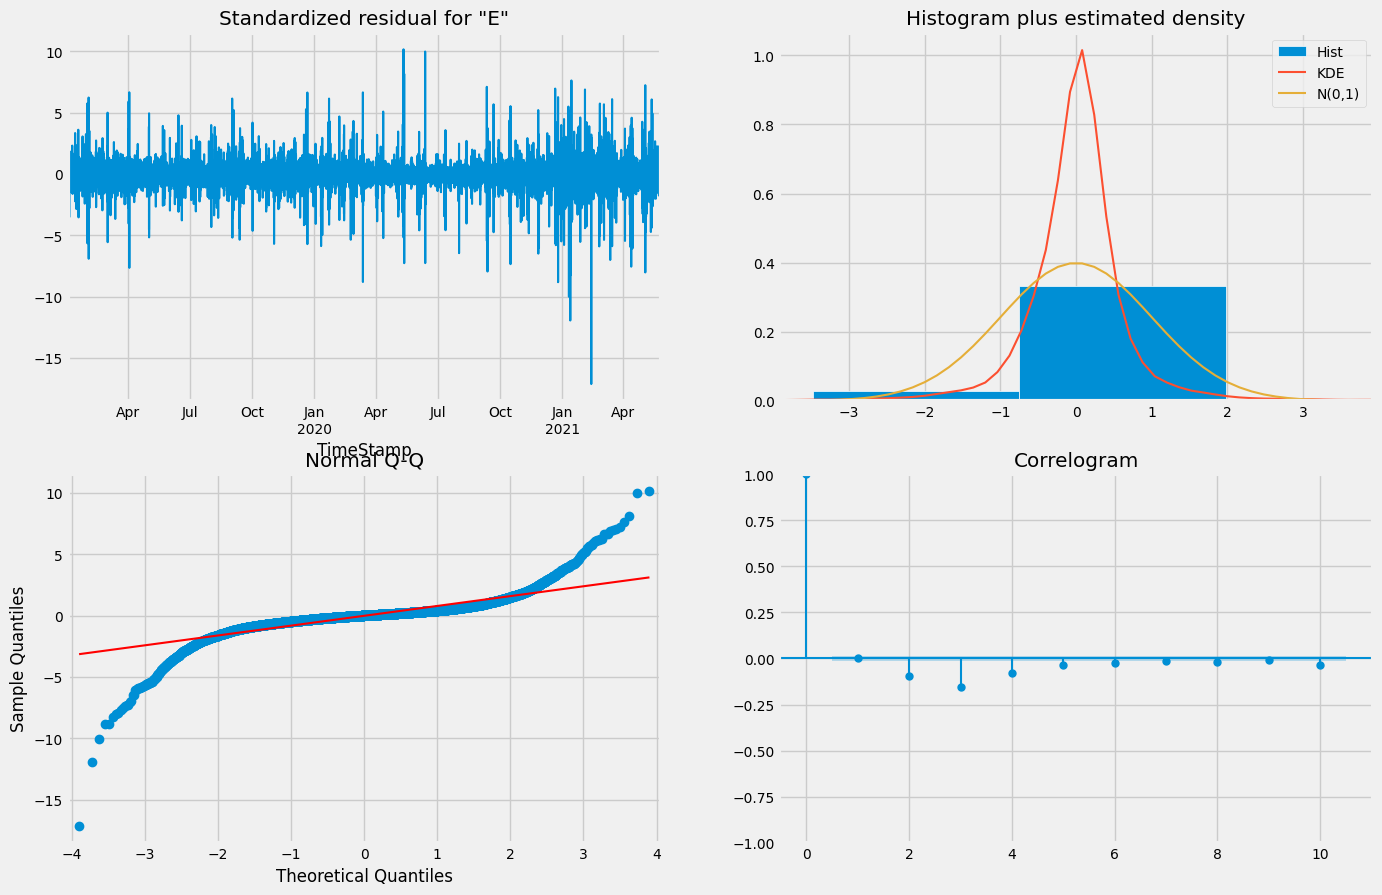

In [18]:
results.plot_diagnostics(figsize=(15, 10))
plt.show()

In [19]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                     
=========================================================================================
Dep. Variable:                  ElectricityPrice   No. Observations:                21043
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 7)   Log Likelihood              -81723.820
Date:                           Mon, 03 Jul 2023   AIC                         163487.641
Time:                                   15:07:09   BIC                         163646.711
Sample:                               01-01-2019   HQIC                        163539.558
                                    - 05-26-2021                                         
Covariance Type:                             opg                                         
======================================================================================
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
IE Generation         -0.0002      0.002     -0.152      0.879      -0.003       0.003
IE Demand              0.0205      0.001     16.178      0.000       0.018       0.023
IE Wind Generation     0.0008      0.002      0.407      0.684      -0.003       0.004
SNSP                 -13.6779      7.083     -1.931      0.053     -27.561       0.205
Hydro Run-of-River     0.0494      0.010      4.776      0.000       0.029       0.070
Fossil hard coal       0.0557      0.004     12.973      0.000       0.047       0.064
Fossil oil             0.0014      0.002      0.619      0.536      -0.003       0.006
Fossil peat           -0.0080      0.007     -1.086      0.278      -0.022       0.006
Fossil gas             0.0039      0.001      2.598      0.009       0.001       0.007
temp                  -0.2004      0.172     -1.166      0.244      -0.537       0.136
rhum                  -0.0420      0.033     -1.256      0.209      -0.108       0.024
day                   -0.6247      0.059    -10.622      0.000      -0.740      -0.509
month                  1.2021      0.791      1.520      0.128      -0.348       2.752
hour                  -0.5142      0.016    -32.106      0.000      -0.546      -0.483
dayofweek              0.0548      0.129      0.423      0.672      -0.199       0.308
ar.L1                 -0.1529      0.031     -4.961      0.000      -0.213      -0.092
ma.L1                  0.3283      0.031     10.671      0.000       0.268       0.389
ar.S.L7               -0.0633      0.008     -7.798      0.000      -0.079      -0.047
ma.S.L7               -0.9988      0.001  -1037.194      0.000      -1.001      -0.997
sigma2               198.5235      0.889    223.350      0.000     196.781     200.266
===================================================================================
Ljung-Box (L1) (Q):                   0.03   Jarque-Bera (JB):            961828.15
Prob(Q):                              0.87   Prob(JB):                         0.00
Heteroskedasticity (H):               1.88   Skew:                            -0.96
Prob(H) (two-sided):                  0.00   Kurtosis:                        36.08
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [20]:
steps = len(test_df)
pred = results.get_forecast(steps=steps, exog=test_df.loc[:, exogenous_features])

In [21]:
y_test=test_df['ElectricityPrice']
y_pred=pred.predicted_mean

In [22]:
print('RMSE:',mean_squared_error(y_test, y_pred, squared = False))
print('MSE:',mean_squared_error(y_test, y_pred))
print('MAE:',mean_absolute_error(y_test, y_pred))
print('MAPE:',mean_absolute_percentage_error(y_test, y_pred))
print('Max Error:',max_error(y_test, y_pred))
print('Explained Variance Score:',explained_variance_score(y_test, y_pred))
print('R2Score:',r2_score(y_test, y_pred))

RMSE: 59.80133195315532
MSE: 3576.1993033714753
MAE: 48.85620057144116
MAPE: 702235673586407.1
Max Error: 167.55888982706378
Explained Variance Score: 0.20545548854726725
R2Score: 0.13674234290828824


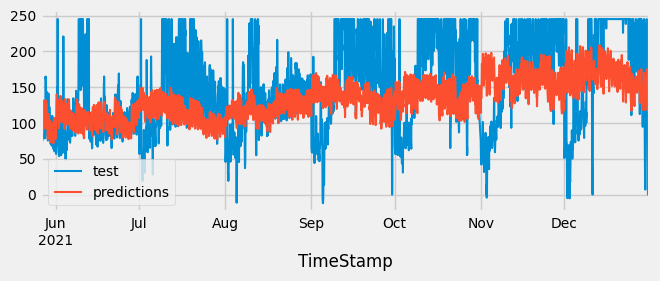

In [23]:
fig, ax = plt.subplots(figsize=(7, 2.5))
#train_df['ElectricityPrice'].plot(ax=ax, label='train')
y_test.plot(ax=ax, label='test')
y_pred.plot(ax=ax, label='predictions')
ax.legend();

In [24]:
pred_data=df.copy()
pred_data['TimeStamp'] = pd.to_datetime(pred_data['TimeStamp'], format='%Y-%m-%dT%H:%M:%SZ')

In [25]:
pred_data=pred_data.drop(pred_data[pred_data['TimeStamp']<=pd.to_datetime('31-12-2021  23:00:00')].index)
pred_data.shape

(4319, 17)

In [26]:
pred_data=pred_data.drop(pred_data[pred_data['TimeStamp']>pd.to_datetime('01-07-2022  00:00:00')].index)
pred_data.shape

(145, 17)

In [27]:
pred_data = pred_data.set_index('TimeStamp')
pred_data = pred_data.asfreq('H')
pred_data = pred_data.sort_index()

In [ ]:
last_window = test_df['ElectricityPrice'].tail(50)

In [ ]:
start = test_df.index[0] #(=431)
end = test_df.index[-1] #(=721)

In [28]:
exog = pred_data.loc[:, pred_data.columns != 'ElectricityPrice']+pred_data.loc[:, pred_data.columns != 'ElectricityPrice']

In [29]:
y_pred = results.forecast(steps=145, exog=pred_data.loc[:, pred_data.columns != 'ElectricityPrice'])

In [30]:
plottest=test_df.drop(test_df[test_df.index<pd.to_datetime('20-12-2021  23:00:00')].index)

In [31]:
pred_ci = pred.conf_int()

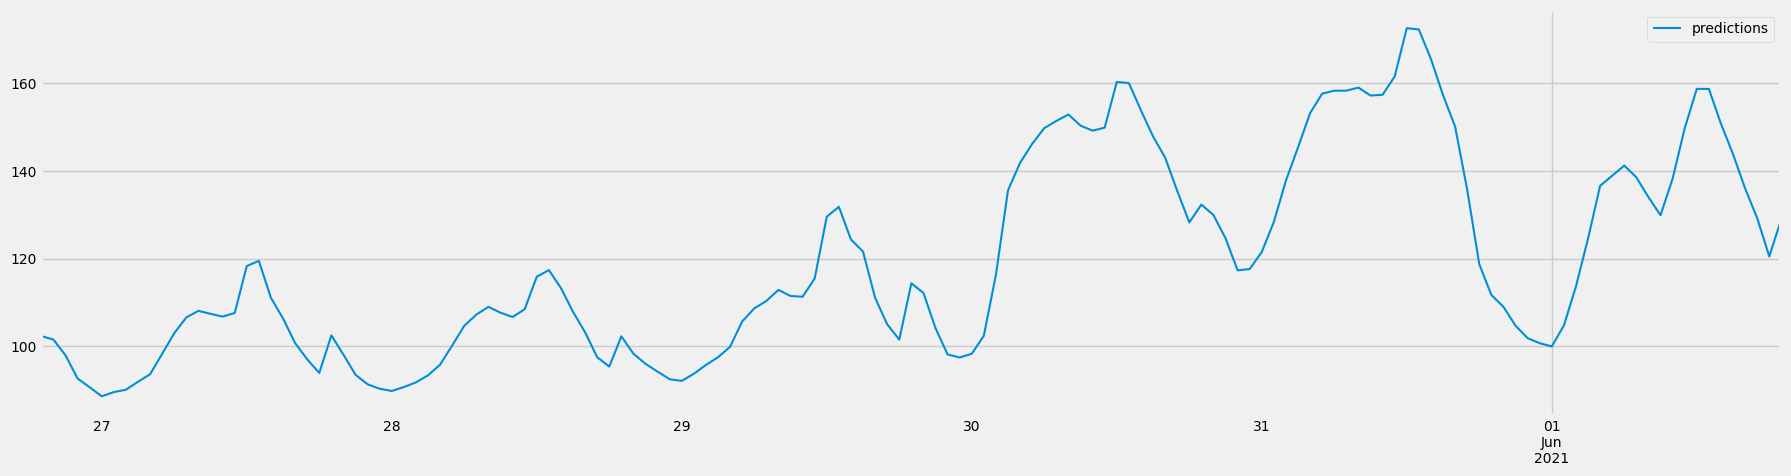

In [36]:
fig, ax = plt.subplots(figsize=(20, 5))

#pred_data['IE Demand'].plot(ax=ax, label='test')
#plottest['IE Demand'].plot(ax=ax, label='test')
y_pred.plot(ax=ax, label='predictions')
#pred_ci.plot(ax=ax, label='confidence interval')
ax.legend();
plt.show()